In [1]:
import numpy as np
import os
import pysam
import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

/Users/suhang/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-26 21:08:47.701627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_forward_read_to_ref_mapping(read):
    """
    Create a mapping from forward read positions to reference positions.
    
    Args:
        read: A pysam AlignedSegment object
        
    Returns:
        Dictionary mapping forward read positions to reference positions
    """
    # Get aligned pairs from the read
    aligned_pairs = read.get_aligned_pairs(matches_only=False)
    
    # Create the mapping dictionary
    forward_read_to_ref = {}
    
    if not read.is_reverse:
        # For forward reads, just map read positions to reference positions
        for read_pos, ref_pos in aligned_pairs:
            if read_pos is not None:  # Skip soft-clipped bases with no read position
                forward_read_to_ref[read_pos] = ref_pos
    else:
        # For reverse reads, we need to convert read positions to forward orientation
        read_length = read.query_length
        
        for read_pos, ref_pos in aligned_pairs:
            if read_pos is not None:
                # Convert reverse read position to forward orientation
                forward_pos = read_length - read_pos - 1
                forward_read_to_ref[forward_pos] = ref_pos
    
    return forward_read_to_ref


               
def get_methylated_matrix1(filename, sampleid, mod = "m"):
    bam_file = pysam.AlignmentFile(filename, "rb")
    matrix_df = {}
    labels = {}
    for read in bam_file.fetch():
        if read.is_unmapped:
            continue   
        read_name = read.query_name
        matrix_df[read_name] = matrix_df.get(read_name, {})
        labels[read_name] = sampleid
        if read.has_tag("Mm") or read.has_tag("Ml") or read.has_tag("MM") or read.has_tag("ML"):

            for modtype in read.modified_bases_forward:
                if modtype[2] != mod:
                    continue

                ref_map = get_forward_read_to_ref_mapping(read)
                # ref_index = dict([x for x in ref_pos if x[0] is not None])

                if len(read.modified_bases_forward) > 0:
                    for pos, qual in read.modified_bases_forward[modtype]:
                        if ref_map[pos] is not None:
                            methstate = 0
                            if qual/255 > 0.8:
                                methstate = 1

                            if qual/255 < 0.2:
                                methstate = -1
                            matrix_df[read_name][ref_map[pos]] = qual/255.0

    return matrix_df, labels

In [3]:
directory = "./"
filelist = os.listdir(directory)
bamfiles = [fp for fp in filelist if fp.endswith("mt_test.bam")]
all_data = {}
all_labels = {}
sampleid = 0

for bamfile in bamfiles:
    filename = directory + bamfile
    print(filename)
    matrix_df, labels = get_methylated_matrix1(filename, sampleid, mod = 'm')
    all_data.update(matrix_df)
    all_labels.update(labels)
    sampleid += 1

./mt_test.bam


In [4]:
import pandas as pd
df = pd.DataFrame(all_data)
df[df.isna()] = 0
df = df.sort_index()
matrix = df.values
print(matrix.shape)
df

(1480, 2611)


,m64011_190901_095311/1311733/ccs,m64011_190901_095311/1837241/ccs,m64011_190901_095311/3148195/ccs,m64011_190901_095311/4457474/ccs,m64011_190901_095311/4850369/ccs,m64011_190901_095311/7078145/ccs,m64011_190901_095311/7340639/ccs,m64011_190901_095311/8388851/ccs,m64011_190901_095311/8651920/ccs,m64011_190901_095311/10093491/ccs,...,m64011_190830_220126/95423223/ccs,m64011_190901_095311/20121533/ccs,m64011_190830_220126/10618144/ccs,m64011_190830_220126/39978939/ccs,m64011_190901_095311/148243182/ccs,m64011_190901_095311/461565/ccs,m64011_190901_095311/30868362/ccs,m64012_190921_234837/21693602/ccs,m64011_190830_220126/129106831/ccs,m64011_190901_095311/59902565/ccs
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.196078,0.509804,0.207843,0.054902,0.074510,0.254902,0.035294,0.286275,0.054902,0.231373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.023529,0.054902,0.360784,0.109804,0.031373,0.031373,0.003922,0.086275,0.968627,0.811765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16541,0.035294,0.168627,0.066667,0.141176,0.474510,0.921569,0.086275,0.443137,0.545098,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16564,0.152941,0.109804,0.011765,0.341176,0.694118,0.007843,0.003922,0.003922,0.054902,0.047059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Users/suhang/miniconda3/lib/python3.10/site-packages/umap_learn-0.5.5-py3.10.egg/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0, 0.5, 'umap_y')

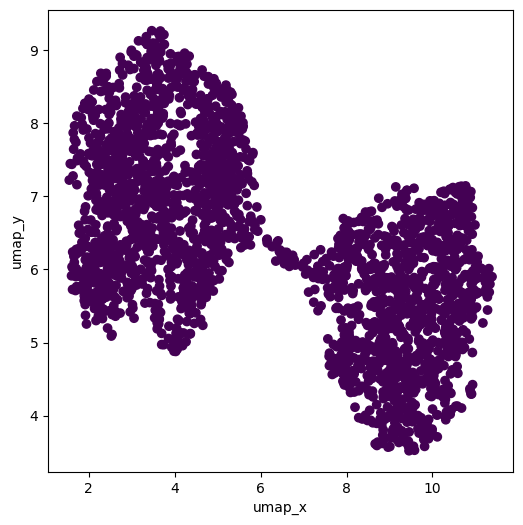

In [5]:
import umap

n_neighbors=5
min_dist=0.1

umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
embedding = umap_reducer.fit_transform(matrix.T)
umap_x = embedding[:, 0]
umap_y = embedding[:, 1]

plt.figure(figsize=(6,6))
plt.scatter(umap_x,umap_y, c = [all_labels[item] for item in df.columns])
plt.xlabel('umap_x')
plt.ylabel('umap_y')

NameError: name 'explained_variance' is not defined

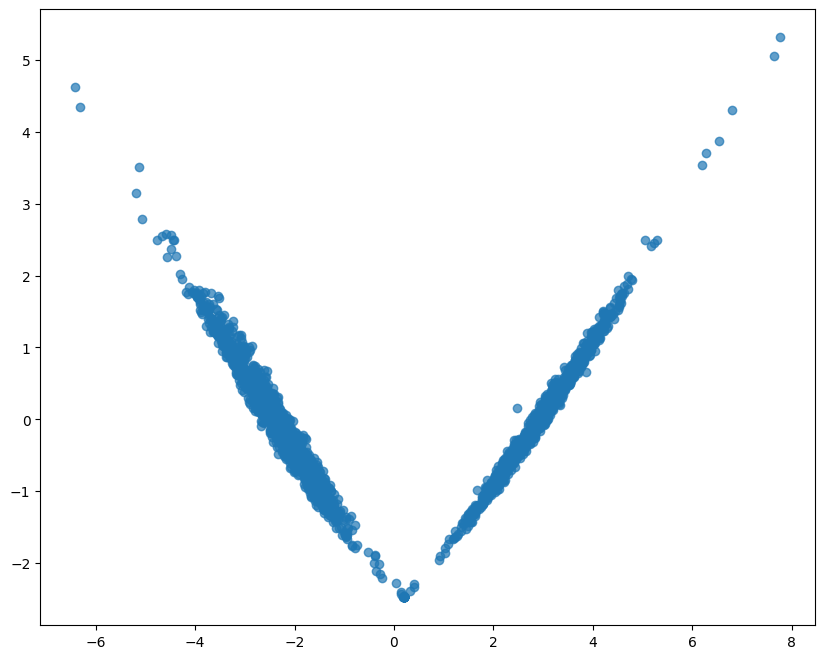

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


n_components = 2  # Number of principal components to keep
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(matrix.T)

plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.7)
plt.xlabel(f'PC1 ({explained_variance[0]:.2%})')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%})')
plt.title('PCA of Methylation Data')


In [7]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(matrix.T)

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(embedding)

/Users/suhang/miniconda3/lib/python3.10/site-packages/umap_learn-0.5.5-py3.10.egg/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/suhang/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [25]:
c1_index = np.where(clusters == 0)[0]
df_c1 = df.iloc[:, c1_index]
df_c1 = (df_c1 > 0.8).sum(axis = 1)
df_cluster1 = pd.DataFrame([])
df_cluster1['methylated'] = df_c1
df_cluster1['coverage'] = len(c1_index)


In [27]:
df_cluster1.to_csv("cluster1.csv")

In [28]:
c1_index = np.where(clusters == 1)[0]
df_c1 = df.iloc[:, c1_index]
df_c1 = (df_c1 > 0.8).sum(axis = 1)
df_cluster1 = pd.DataFrame([])
df_cluster1['methylated'] = df_c1
df_cluster1['coverage'] = len(c1_index)
df_cluster1.to_csv("cluster2.csv")

In [68]:
annotation_file = "./rCRS.gff3"
gene_info = {}
with open(annotation_file, 'r') as fp:
    data = fp.readlines()
count = 0
for line in data:
    if line.startswith("#"):
        continue
    itemlist = line.split("\t")
    if len(itemlist) < 2:
        continue
    t = itemlist[2]
    startpos = int(itemlist[3])
    endpost = int(itemlist[4])
    infor = itemlist[8]
    name = ""
    for item in infor.split(";"):
        if item.startswith("Name"):
            name = item.split("=")[1]
    if t == "gene":
        gene_info[name] = (startpos, endpos)


In [69]:
gene_info

{'TRNF': (577, 14458),
 'RNR1': (648, 14458),
 'TRNV': (1602, 14458),
 'RNR2': (1671, 14458),
 'TRNL1': (3230, 14458),
 'ND1': (3307, 14458),
 'TRNI': (4263, 14458),
 'TRNQ': (4329, 14458),
 'TRNM': (4402, 14458),
 'ND2': (4470, 14458),
 'TRNW': (5512, 14458),
 'TRNA': (5587, 14458),
 'TRNN': (5657, 14458),
 'TRNC': (5761, 14458),
 'TRNY': (5826, 14458),
 'COX1': (5904, 14458),
 'TRNS1': (7446, 14458),
 'TRND': (7518, 14458),
 'COX2': (7586, 14458),
 'TRNK': (8295, 14458),
 'ATP8': (8366, 14458),
 'ATP6': (8527, 14458),
 'COX3': (9207, 14458),
 'TRNG': (9991, 14458),
 'ND3': (10059, 14458),
 'TRNR': (10405, 14458),
 'ND4L': (10470, 14458),
 'ND4': (10760, 14458),
 'TRNH': (12138, 14458),
 'TRNS2': (12207, 14458),
 'TRNL2': (12266, 14458),
 'ND5': (12337, 14458),
 'ND6': (14149, 14458),
 'TRNE': (14674, 14458),
 'CYTB': (14747, 14458),
 'TRNT': (15888, 14458),
 'TRNP': (15956, 14458)}

In [70]:
import numpy
cmap = plt.get_cmap('viridis')
# cmap = ["r", "green", "blue"]
def plot_dmr(df, clusters, start, end, window_size = 100):

    for i in [0,1]:
        cluster_index = numpy.where(clusters == i)[0]
        df_subset = df.iloc[:, cluster_index]
        # cluster_sum_up_signal_perbase = numpy.mean(matrix.T[cluster_index], axis = 0)
        
        x = np.array(df.index.tolist())
        y = np.sum(df_subset > 0.9,axis = 1)/len(cluster_index)
        # y = cluster_sum_up_signal_perbase
        assert len(x) == len(y)
        mask = ~np.isnan(y)
        x_valid = x[mask]
        y_valid = y[mask]

        kernel = np.ones(window_size) / window_size
        y_smooth = np.convolve(y, kernel, mode='same')

        # Fix edge effects
        half_window = window_size // 2
        y_smooth[:half_window] = y_valid[:half_window]
        y_smooth[-half_window:] = y_valid[-half_window:]


        plt.plot(x, y_smooth, c = cmap(i/1), label = "cluster" + str(i))

    ax1.set_ylabel("methylated fractions")
    ax1.legend()
    ax1.set_xlim([start, end])
    plt.xlim([start, end])


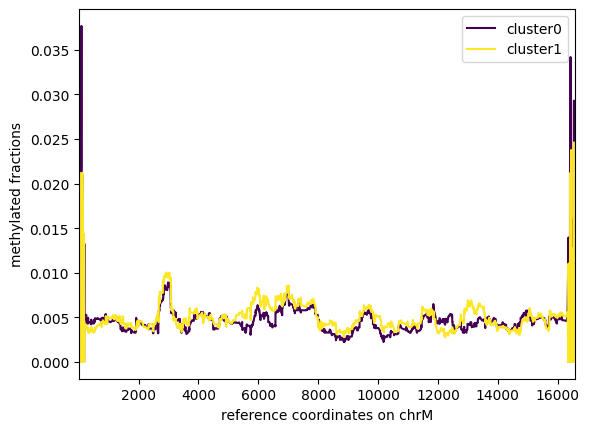

In [59]:
plot_dmr(df, clusters, 1, 16569, window_size = 50)

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_dmr_withgene(df, clusters, start, end, window_size=100, gene_info=None, figsize=(10, 8)):
    """
    Plot methylation data with a gene track.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Methylation data with positions as index
    clusters : array
        Cluster assignments for each sample
    start, end : int
        Region to plot
    window_size : int
        Window size for smoothing
    gene_info : dict
        Dictionary with gene names as keys and (start, end) tuples as values
    figsize : tuple
        Figure size
    """
    # Create a figure with two subplots - methylation plot and gene track
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # Set the active axis to the top plot for methylation data
    plt.sca(ax1)
    
    for i in [0, 1]:
        cluster_index = numpy.where(clusters == i)[0]
        df_subset = df.iloc[:, cluster_index]
        
        x = np.array(df.index.tolist())
        y = np.sum(df_subset > 0.9, axis=1) / len(cluster_index)
        
        assert len(x) == len(y)
        mask = ~np.isnan(y)
        x_valid = x[mask]
        y_valid = y[mask]

        kernel = np.ones(window_size) / window_size
        y_smooth = np.convolve(y, kernel, mode='same')

        # Fix edge effects
        half_window = window_size // 2
        y_smooth[:half_window] = y_valid[:half_window]
        y_smooth[-half_window:] = y_valid[-half_window:]

        ax1.plot(x, y_smooth, c=cmap(i/1), label="cluster" + str(i))

    ax1.set_ylabel("methylated fractions")
    ax1.legend()
    ax1.set_xlim([start, end])
    
    # Add gene track in the bottom subplot
    if gene_info is not None:
        # Set y-axis limits for gene track
        ax2.set_ylim(0, 1)
        ax2.set_yticks([])  # Hide y-axis ticks for gene track
        
        # Plot each gene as a rectangle
        gene_height = 0.3
        y_pos = 0.5 - gene_height/2
        
        genes_in_region = []
        for gene_name, (gene_start, gene_end) in gene_info.items():
            # Check if gene overlaps with the current region
            if gene_end >= start and gene_start <= end:
                genes_in_region.append((gene_name, gene_start, gene_end))
        
        # Sort genes by start position for better visualization
        genes_in_region.sort(key=lambda x: x[1])
        
        # Distribute genes vertically if they overlap
        occupied_regions = []
        
        for gene_name, gene_start, gene_end in genes_in_region:
            # Clip gene to plot region
            plot_gene_start = max(gene_start, start)
            plot_gene_end = min(gene_end, end)
            
            # Find a suitable y-position (avoid overlaps)
            current_y = 0.1
            placed = False
            
            while not placed and current_y < 0.9:
                overlap = False
                for occ_start, occ_end, occ_y in occupied_regions:
                    # Check for overlap
                    if (plot_gene_start <= occ_end and plot_gene_end >= occ_start and 
                        abs(current_y - occ_y) < gene_height):
                        overlap = True
                        break
                
                if not overlap:
                    # Place the gene here
                    rect = Rectangle((plot_gene_start, current_y - gene_height/2), 
                                    plot_gene_end - plot_gene_start, 
                                    gene_height, 
                                    facecolor='skyblue', 
                                    edgecolor='navy', 
                                    alpha=0.7)
                    ax2.add_patch(rect)
                    
                    # Add gene name
                    ax2.text(plot_gene_start, #(plot_gene_start + plot_gene_end)/2, 
                            current_y, 
                            gene_name, 
                            ha='center', 
                            va='center', 
                            fontsize=8)
                    
                    occupied_regions.append((plot_gene_start, plot_gene_end, current_y))
                    placed = True
                else:
                    current_y += gene_height
            
            # If we couldn't place it, just put it at the bottom
            if not placed:
                rect = Rectangle((plot_gene_start, 0.1 - gene_height/2), 
                                plot_gene_end - plot_gene_start, 
                                gene_height, 
                                facecolor='skyblue', 
                                edgecolor='navy', 
                                alpha=0.7)
                ax2.add_patch(rect)
                ax2.text((plot_gene_start + plot_gene_end)/2, 0.1, gene_name, 
                        ha='center', va='center', fontsize=8)
    
    ax2.set_xlabel("reference coordinates on chrM")
    ax2.set_ylabel("Genes")
    
    plt.tight_layout()
    return fig



In [89]:
# gene_info
gene_info_excluded = {}
for name, item in gene_info.items():
    if name.startswith("TR"):
        continue
    if item[1] - item[0] > 10000:
        continue
    gene_info_excluded[name] = item

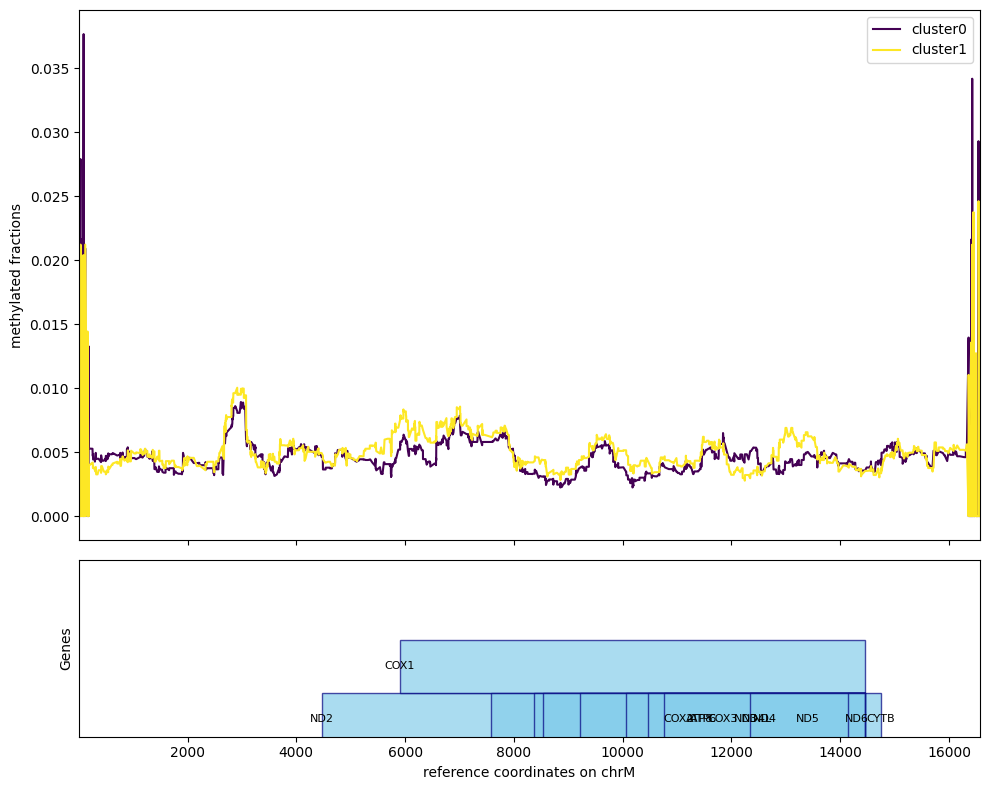

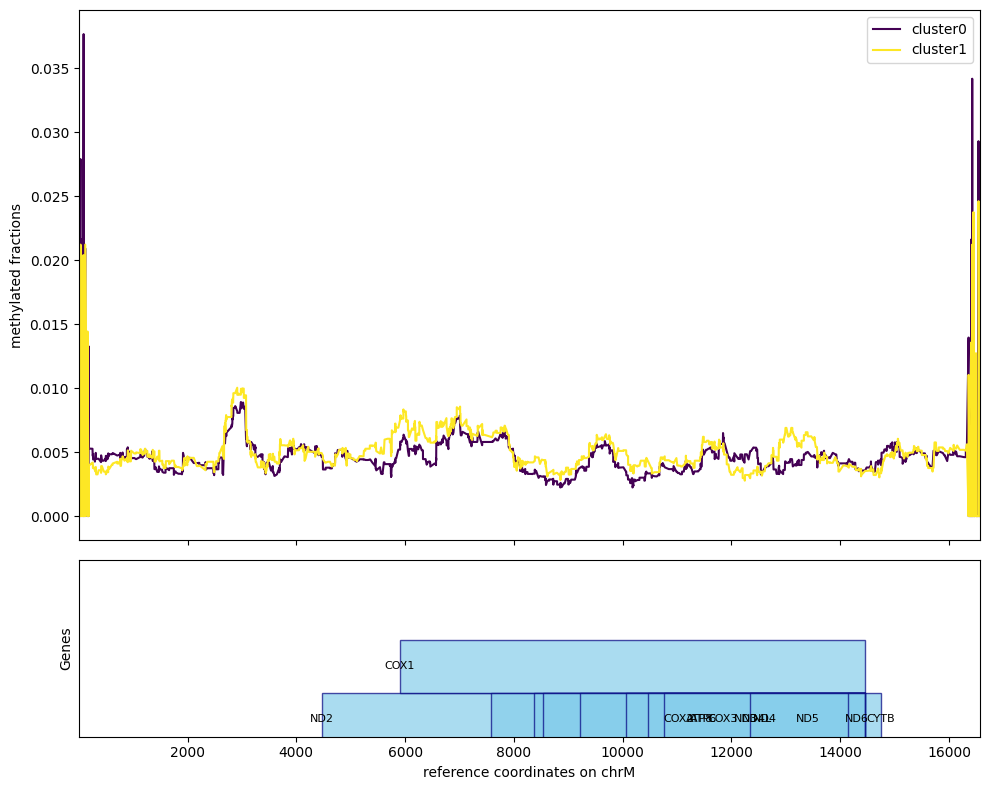

In [90]:
# Example usage:
# gene_info = {'TRNF': (577, 647), 'RNR1': (648, 1601), ...}
plot_dmr_withgene(df, clusters, 1, 16569, window_size=50, gene_info=gene_info_excluded)

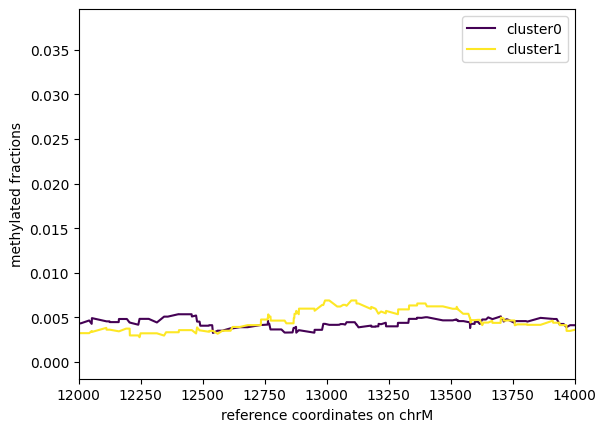

In [61]:
plot_dmr(df, clusters, 12000, 14000, window_size = 50)

<Figure size 500x600 with 0 Axes>

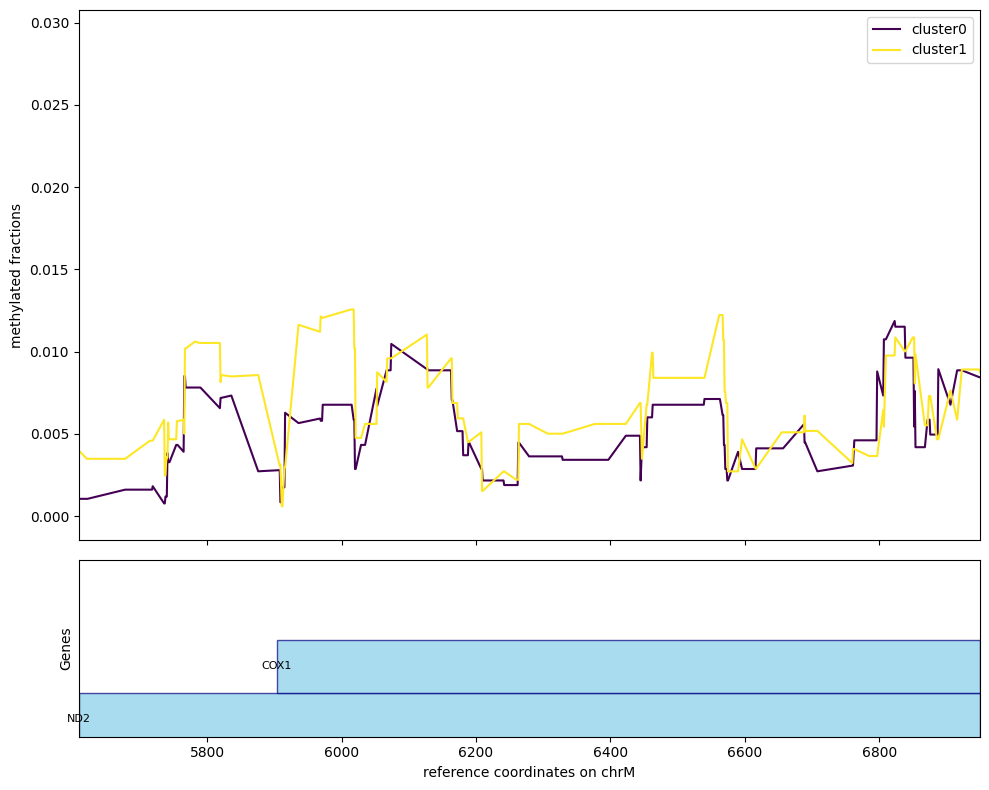

<Figure size 500x600 with 0 Axes>

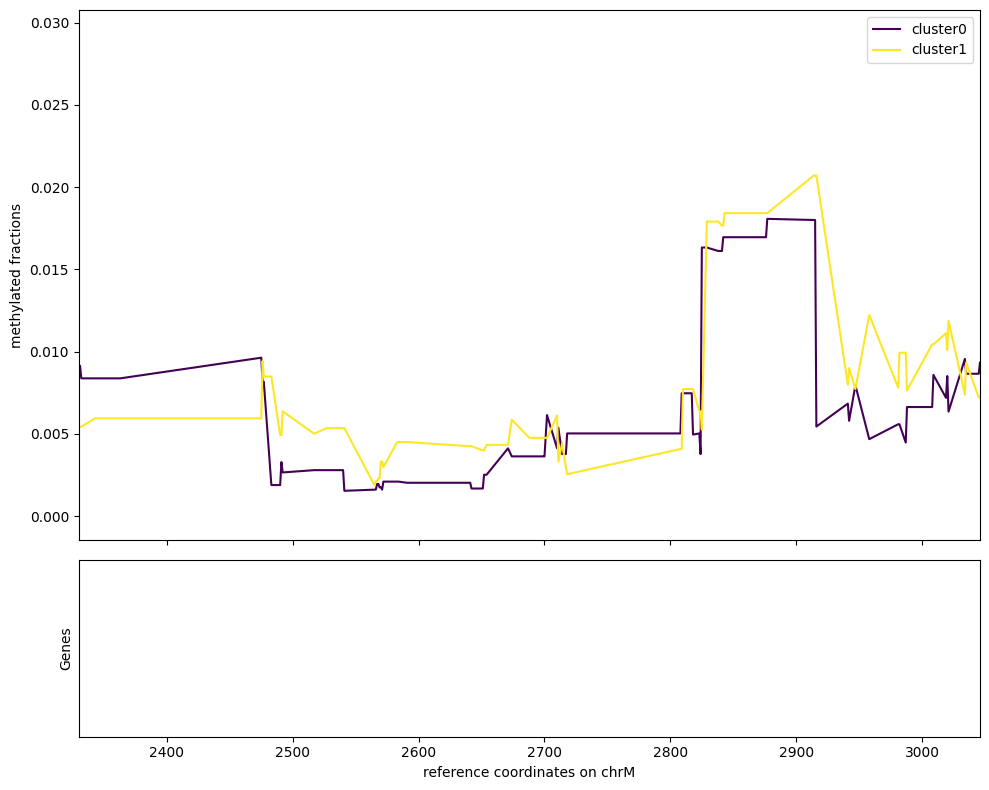

<Figure size 500x600 with 0 Axes>

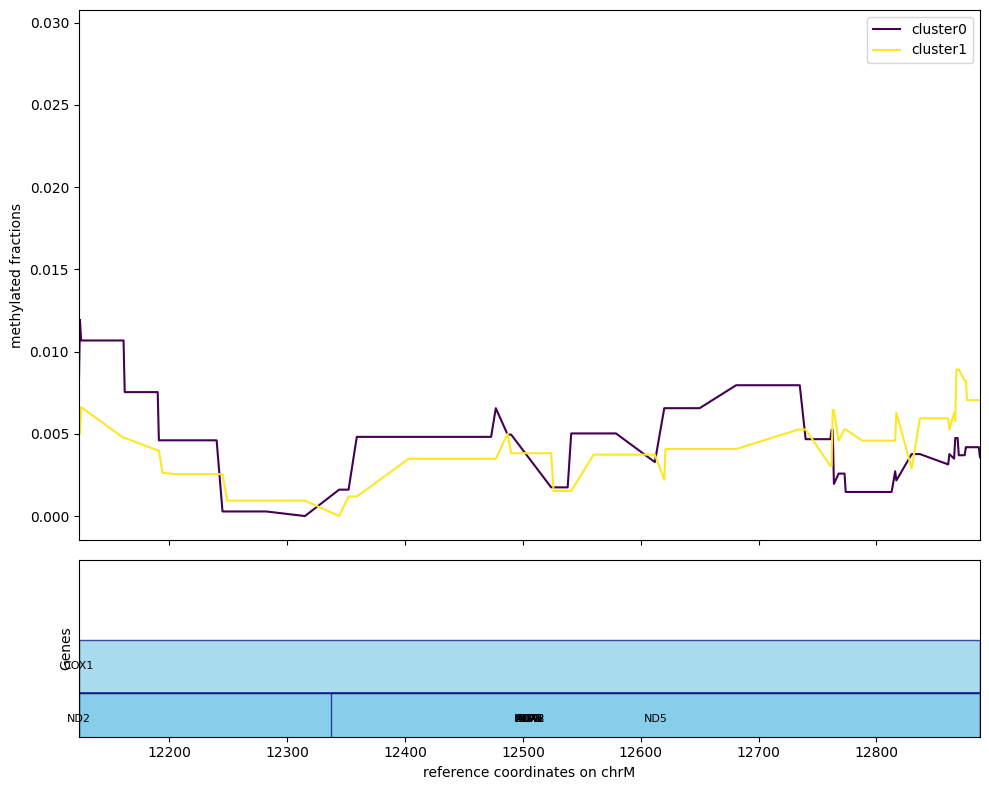

<Figure size 500x600 with 0 Axes>

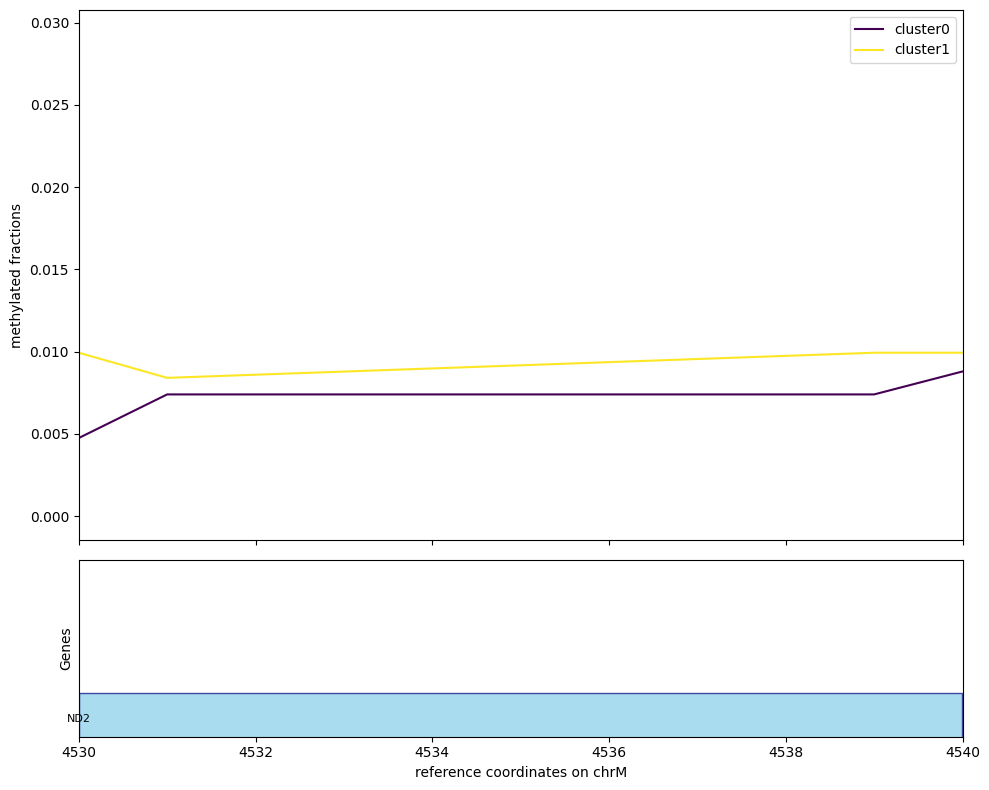

<Figure size 500x600 with 0 Axes>

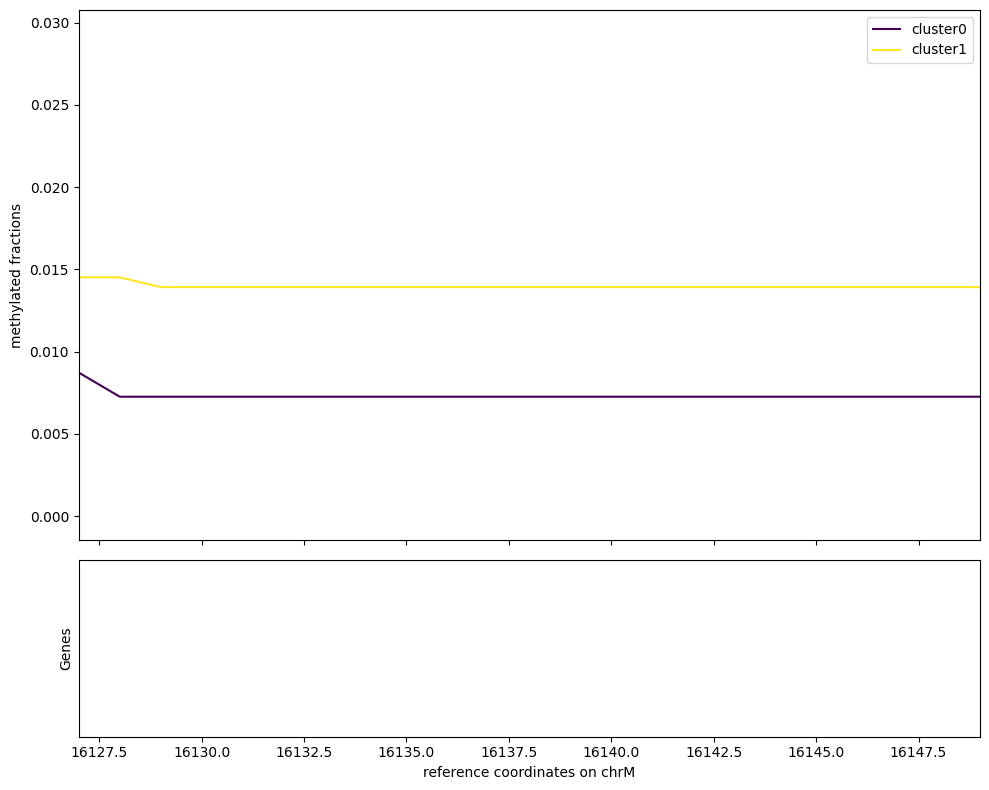

<Figure size 500x600 with 0 Axes>

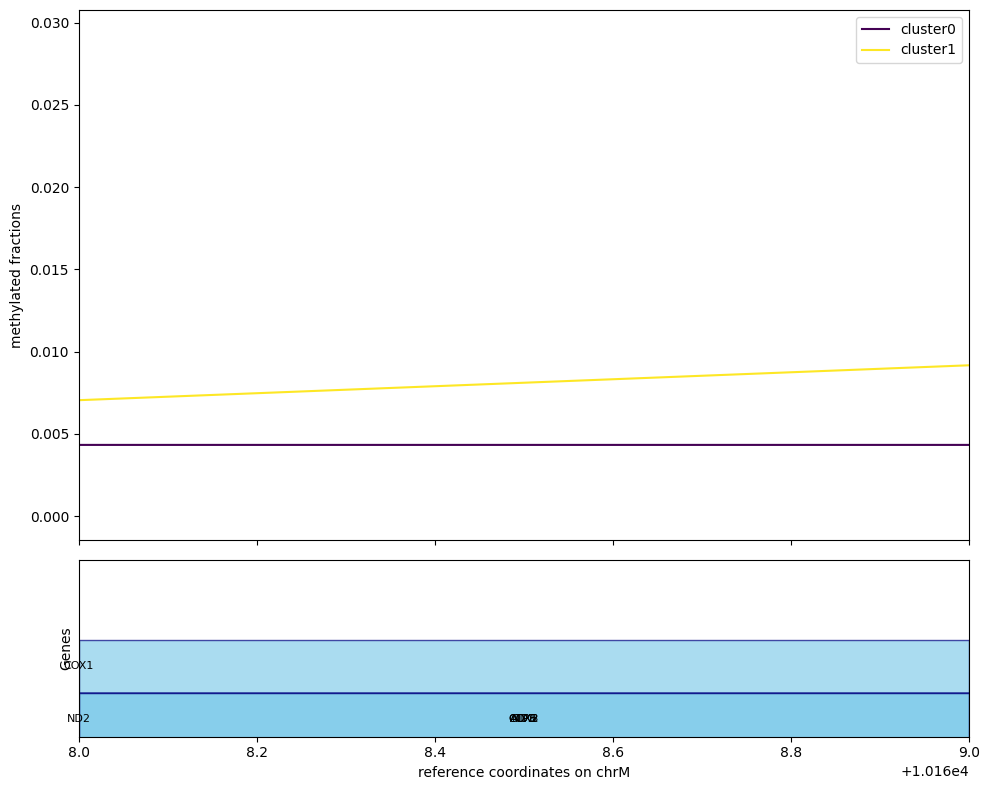

<Figure size 500x600 with 0 Axes>

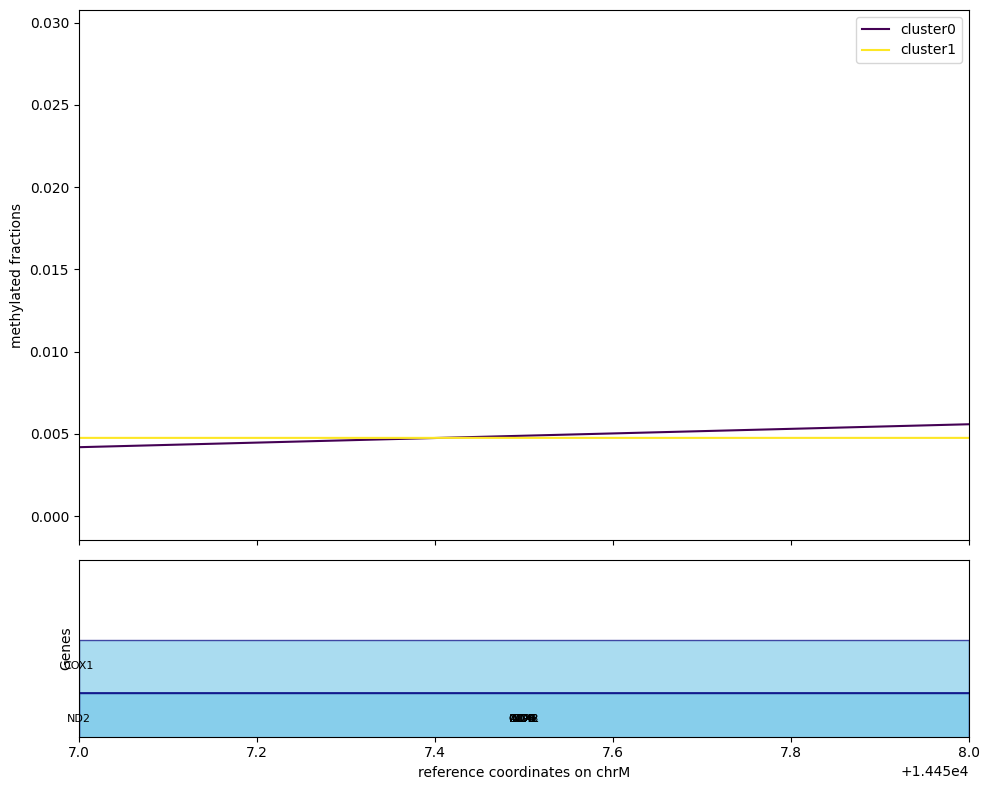

In [94]:
# dmr regions
dmr_regions = pd.read_csv("./dmr_regions.csv")
dmr_regions
for index, row in dmr_regions.iterrows():
    startpos = row['start']
    endpos = row['end']
    figure = plt.figure(figsize=[5,6])
    plot_dmr_withgene(df, clusters, startpos, endpos, window_size = 10, gene_info=gene_info_excluded)


    